# Spatial Math Warmup

In [1]:
!pip install spatialmath-python
!pip install --upgrade numpy


  Using cached numpy-1.22.4-cp39-cp39-macosx_10_15_x86_64.whl (17.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.22.4 which is incompatible.
  Using cached numpy-1.26.4-cp39-cp39-macosx_10_9_x86_64.whl (20.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which i

In [27]:
import numpy as np
from spatialmath import *
from math import pi

import matplotlib.pyplot as plt
%matplotlib notebook 

## Localisation Problem

In this notebook, we see a possible way for an object to do locate itself according to the world frame (assuming it has a camera which detects objects in its frame)

- A = The World Frame
- B = Robot Location (with camera)
- Cn where n is 1,2,3 = The different landmarks 

We assume that we have the landmarks pose in the world frame through previous means

In [28]:
Ha = SE3(0,0,0)
Hb = SE3(2.8,0.5, 0)
Hc1 = SE3.Tx(1.0) * SE3.Ty(1.0) * SE3.Tz(2) * SE3.Rz(-45, 'deg')* SE3.Ry(45, 'deg')* SE3.Rx(45, 'deg')
Hc2 = SE3.Tx(2) * SE3.Ty(3) * SE3.Tz(3) * SE3.Rz(60, 'deg')* SE3.Ry(60, 'deg')* SE3.Rx(-60, 'deg')
Hc3 = SE3.Tx(4) * SE3.Ty(4) * SE3.Tz(3) * SE3.Rz(60, 'deg')* SE3.Ry(180, 'deg')* SE3.Rx(60, 'deg')

# Hbcn = Hba * Hacn --> Hbcn = (Hab)^-1 * Hacn
Hbc1 = Hb.inv() * Hc1
Hbc2 = Hb.inv() * Hc2
Hbc3 = Hb.inv() * Hc3



<IPython.core.display.Javascript object>


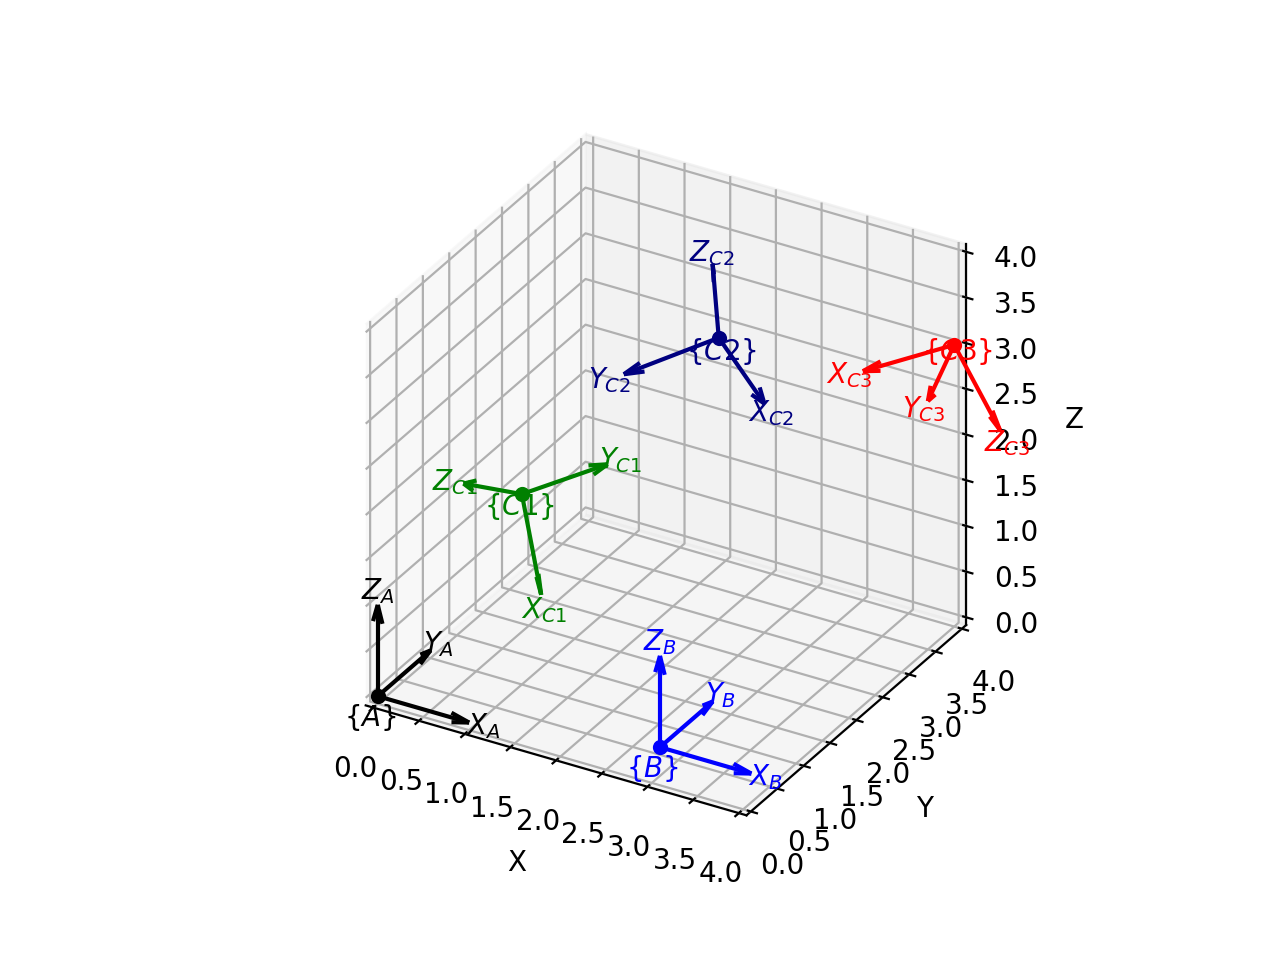

In [22]:
Ha.plot(frame='A', color='black', dims=[0,4])
#Robot location is (2.8,0.5,0)
Hb.plot(frame='B', color='blue', dims=[0,4])
Hc1.plot(frame='C1', color='green', dims=[0,4])
Hc2.plot(frame='C2', color='navy', dims=[0,4])
Hc3.plot(frame='C3', color='red', dims=[0,4])

In [28]:
# In this localisation problem, we get we get all the information in the frame of the camera (B). 
# We will use HBC1, HBC2, and HBC3 to get a localisation of B
# HB = (HAC1 * HC1B + HAC2 * HC2B + HAC3 * HAC3) / 3

answer = Hc1 * Hbc1.inv()

In [29]:
answer

   1         0         0         2.8       
   0         1         0         0.5       
   0         0         1         0         
   0         0         0         1         


In [27]:
Hb

   1         0         0         2.8       
   0         1         0         0.5       
   0         0         1         0         
   0         0         0         1         


Here we see that a single landmark is enough to get the location of robot B, but this may not be accurate so we can use three landmarks and an aggregation for a better estimate.

# Open3d Visualisation Project

In [30]:
!pip install open3d

     |████████████████████████████████| 74.4 MB 248 kB/s eta 0:00:011    |████████▎                       | 19.4 MB 883 kB/s eta 0:01:03        | 52.7 MB 345 kB/s eta 0:01:03     |███████████████████████████▏    | 63.2 MB 1.0 MB/s eta 0:00:11
     |████████████████████████████████| 10.2 MB 4.3 MB/s eta 0:00:01
     |████████████████████████████████| 75 kB 7.7 MB/s eta 0:00:011
  Using cached numpy-1.22.4-cp39-cp39-macosx_10_15_x86_64.whl (17.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.3.0
    Uninstalling nbformat-5.3.0:
      Successfully uninstalled nbformat-5.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not install

In [5]:
import open3d as o3d
import numpy as np
import time
import copy



In [81]:
def create_camera_wireframe(center):
    # Define camera dimensions
    h = 0.1  # Height of the camera box
    w = 0.05  # Width of the camera box
    l = 0.05  # Length of the camera box
    rotation = 0

    # Define the vertices of the camera box
    vertices = np.array([
        # Bottom face
        
        [center[0] - l / 2, center[1] - w / 2, center[2] - h / 2],
        [center[0] + l / 2, center[1] - w / 2, center[2] - h / 2],
        [center[0] + l / 2, center[1] + w / 2, center[2] - h / 2],
        [center[0] - l / 2, center[1] + w / 2, center[2] - h / 2],
        # Top face
        [center[0] - l / 2, center[1] - w / 2, center[2] + h / 2],
        [center[0] + l / 2, center[1] - w / 2, center[2] + h / 2],
        [center[0] + l / 2, center[1] + w / 2, center[2] + h / 2],
        [center[0] - l / 2, center[1] + w / 2, center[2] + h / 2],
        # Triangle indent
        [center[0] - l / 2, center[1] + w / 3, center[2] + h / 4],
        [center[0] - l / 2, center[1] - w / 3, center[2] + h / 4],
        [center[0] - l / 2, center[1] + w / 3, center[2] - h / 4],
        [center[0] - l / 2, center[1] - w / 3, center[2] - h / 4],
        center
    ])
    
    # Standard 3x3 rotation matrix around the Z axis
    rotation_matrix = np.array([
        [np.cos(rotation), -np.sin(rotation), 0.0],
        [np.sin(rotation), np.cos(rotation), 0.0],
        [0.0, 0.0, 1.0]])

    # Define edges of the camera wireframe
    edges = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Bottom face
        [4, 5], [5, 6], [6, 7], [7, 4],  # Top face
        [0, 4], [1, 5], [2, 6], [3, 7],  # Vertical edges
        [8, 12], [9, 12], [10, 12], 
        [11, 12], [8, 9], [10, 11], [9, 11], [8, 10] # Triangle indent
    ]
    
    # Repeat the [x, y, z] eight times
    twenty_points = np.tile(center, (13, 1))
    
    # Translate the rotated bounding box by the
    # original center position to obtain the final box
    vertices = np.dot(rotation_matrix, vertices.transpose()) + twenty_points.transpose()
    vertices = vertices.transpose()

    return vertices, edges

In [173]:
center = np.array([0, 0, 0])  # Center coordinates of the camera
camera_vertices, lines = create_camera_wireframe(center)

# Use the same color for all lines
colors = [[0, 0, 0] for _ in range(12)]
colors.extend([[1, 0, 0] for _ in range(8)])
line_set = o3d.geometry.LineSet()
line_set.points = o3d.utility.Vector3dVector(camera_vertices)
line_set.lines = o3d.utility.Vector2iVector(lines)
line_set.colors = o3d.utility.Vector3dVector(colors)

This code runs the camera wireframe in a circular motion
- Attempted to rotate camera to face middle at all times, but faced issues.

In [182]:
# Define parameters for circular motion
center = np.array([0, 0, 0])  # Center of the circular path
radius = 0.05  # Radius of the circular path
angular_speed = np.pi / 30  # Angular speed (radians per frame)
angle = 0
x = radius * np.sin(angle)
z = (radius * np.cos(angle))

def rotate_mesh(vis):
    global line_set
    global angle
    global x
    global z
    
    angle = angle + angular_speed
    x = radius * np.sin(angle) - x #world frame
    z = (radius * np.cos(angle)) - z #world frame
    
    Hat = SE3(x,0,z)
    
#     Hba = (SE3() * SE3.Ry(0)).inv()
    
#     Hbt =  Hba * Hat

    T = Hat
    
    line_set = line_set.transform(T)
    vis.update_geometry(line_set)
    vis.update_renderer()
    time.sleep(0)

o3d.visualization.draw_geometries_with_animation_callback([line_set], rotate_mesh)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
